# 학습 목표
**오토인코더** : 레이블 없이 특징을 추출하는 신경망

비지도학습 신경망 오토인코더로 잡음을 제거해 데이터 복원하기.

# 목차
- 오토인코더 기초
- 오토인코더로 이미지의 특징 추출하기
- 오토인코더로 망가진 이미지 복원하기

### 6.1 오토인코더 기초

- **지도 학습** : 입력 x와 정답 y 사이를 잇는 관계 찾기.
정답이 있으면 오차 측정 가능 -> 예측값이 얼마나 틀렸는지, 오차값이 얼마인지 확인 가능.

- **비지도 학습** : '정답이 있으면 오찻값을 구할 수 있다' 아이디어를 빌려 x를 입력받아 x를 예측하고, 신경망에 의미 있는 정보가 쌓이도록 설계된 신경망.

오토 인코더에선 입력도 x, 정답도 x. 단 범용근사자로서 근사치를 출력하기 때문에 x와 똑같은 출력을 내긴 힘들다.

> **범용근사자** : MLP(=Multi-layer perceptron)의 특징. 적절한 활성함수와 적당한 수의 은닉마디를 가지는 MLP는 모든 비선형 곡선을 정확하게 근사시킬 수 있다는 것을 의미.

입력된 x를 **복원**한다는 개념이 더 맞고, 오찻값에도 x를 얼마나 복원했는지를 뜻하는 **복원 오차**(=정보손실값)을 사용한다.


또 다른 특징으로는 입출력의 크기는 같지만, 중간으로 갈수록 **신경망의 차원이 줄어든다**는 특징이 있다. 이런 구조로 정보의 통로가 줄어들고, 병목현상이 일어나 입력의 특징들이 **압축**되도록 학습한다.

작은 차원에 고인 압축된 표현을 **잠재 변수**라고 하고, 간단히 z라고도 한다.

잠재 변수의 앞뒤를 구분하여 앞부분을 인코더(정보 받아 압축), 뒷부분을 디코더(압축된 표현을 풀어 입력을 복원하는 역할)라고 함.

![오토인코더 모델](https://blog.kakaocdn.net/dn/BjYPH/btqX33x3Aj7/Xzq0z4vlXDL35DkBCsqVvk/img.png)

[이미지 출처](https://dsc-sookmyung.tistory.com/81)

신경망이 받은 이미지를 복원하도록 학습하면 잠재 변수에 이미지의 정보가 저장되는데, 낮은 차원에서 높은 밀도로 표현된 데이터이므로 '의미의 압축'이 일어난다.

**의미의 압축** 정보의 손실 -> 덜 중요한 요소를 버리는 과정 -> 정보의 구성에 우선순위가 있단 뜻.

=> 중요한 정보만 남겨두는 일종의 데이터 가공

(컨볼루션 때도 그렇고, 풀링 때도 `정보의 손실 = 중요한 정보 추출하는 가공 작업` 으로 해석되는 게 신기하다)

오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 쓰이며 비정상 거래 검출, 데이터 시각화와 복원, 의미 추출, 이미지 검색 등에도 쓰이고 기계 번역, 생성 모델 등 여러 가지 파생 모델에도 응용되고 있다.


### 6.2 오토인코더로 이미지의 특징 추출하기 

#### 6.2.1 오토인코더 구현

In [3]:
# 필수 라이브러리 import
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

# 이미지 관찰 및 출력용
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # matplotlib에서 3차원 플롯 그리기용
from matplotlib import cm # 데이터 포인트에 색상 입히기용
import numpy as np

# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

# Fashion MNIST 학습 데이터셋 사용. (테스트용x)
trainset = datasets.FashionMNIST(
    root = './.data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

Using Device: cpu


> 📌참고 링크: [DataLoader의 num_workers 파라미터](https://jybaek.tistory.com/799)

In [6]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # 인코더 부분
        self.encoder = nn.Sequential(   # Sequential = 여러 모듈 하나로
            nn.Linear(28*28, 128), # 입력 -> 출력 : 784 -> 128
            nn.ReLU(),
            nn.Linear(128, 64), # 128 -> 64
            nn.ReLU(),
            nn.Linear(64, 12), # 64 -> 12
            nn.ReLU(),
            # 3차원에서 시각화 할 수 있도록
            nn.Linear(12, 3), # 12 -> 3
        )
        
        # 디코더 부분. 인코더와 대칭 형태.
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            
            # 마지막 출력값을 0~1 로 만들어주는 Sigmoid 추가
            nn.Sigmoid(), 
        )
        
    # 데이터 흐름
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

- 최적화 함수로는 **Adam** 사용. 

-> SGD의 변형으로 학습 중인 기울기를 참고하여 학습 속도를 자동으로 변화시킴.

- 오차 함수로는 **평균제곱오차** 사용. 

`nn.MSELoss()` 함수는 두 개의 같은 크기의 행렬을 받아 각 자리의 차이에 제곱해서 평균을 구해주는 객체 생성.

In [16]:
# 모델 생성
autoencoder = Autoencoder().to(DEVICE)

# 최적화 함수 객체 생성
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.005)

# 오차 함수 객체 인스턴스화
criterion = nn.MSELoss()

한 EPOCH이 완료될 때마다 복원이 어떻게 되는지 관찰해보자.

학습 데이터셋에 있는 5개 이미지 가져와 모델에 바로 넣을 수 있도록 간단한 전처리 진행. -> `view_data` 변수에 저장. 

In [17]:
# 원본 이미지 시각화하기
view_data = trainset.data[:5].view(-1, 28 * 28)
view_data = view_data.type(torch.FloatTensor)/255 # 0~1 값으로 만들기

In [18]:
# 학습하는 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        # x, y 모두 원본 이미지(x)
        x = x.view(-1, 28 * 28).to(DEVICE)
        y = x.view(-1, 28 * 28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        # decoded에서 y를 빼고 제곱한 값의 평균을 통해 손실(오차) 구함.
        loss = criterion(decoded, y)
        # 반복문 돌때마다 기울기 구해야하니까 초기화 해주기
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

[Epoch 1]


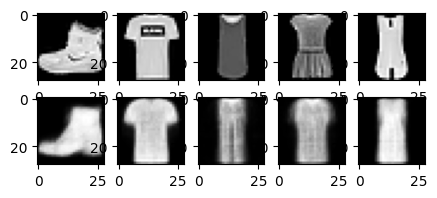

[Epoch 2]


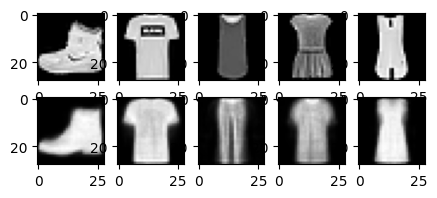

[Epoch 3]


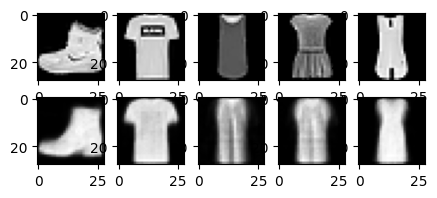

[Epoch 4]


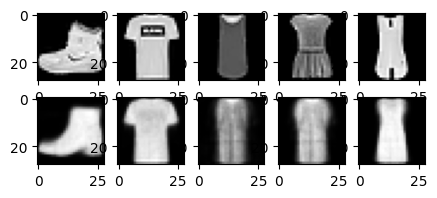

[Epoch 5]


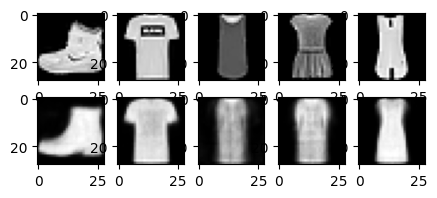

[Epoch 6]


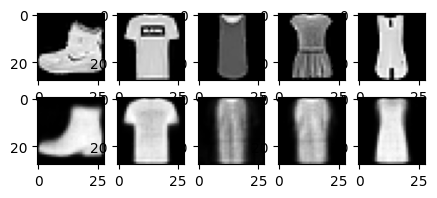

[Epoch 7]


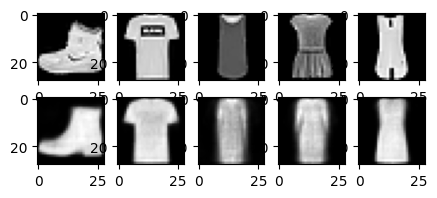

[Epoch 8]


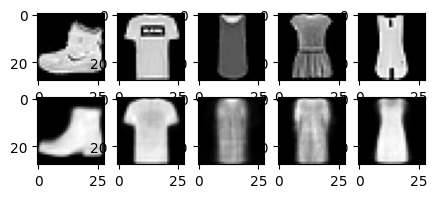

[Epoch 9]


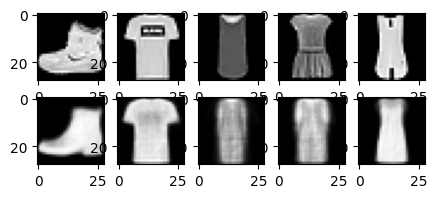

[Epoch 10]


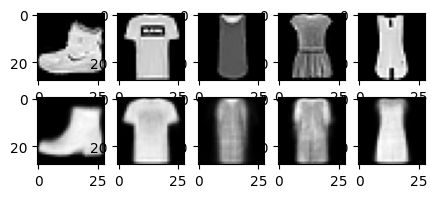

In [19]:
# 학습 실행
for epoch in range(1, EPOCH + 1):
    train(autoencoder, train_loader)
    
    # 아까 남겨둔 5개 이미지를 학습 마친 모델에 넣어 복원 이미지 만들기
    # 디코더에서 나온 이미지 시각화
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    
    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize = (5, 2)) # 틀 생성
    print(f"[Epoch {epoch}]")

    # 원본 이미지 첫 번째 행에 넣기
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28, 28))
        a[0][i].imshow(img, cmap = "gray")

    # 복원된 이미지 두 번째 행에 넣기
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap = "gray")

    plt.show()

#### 6.2.2 잠재 변수 들여다보기
학습 완료된 오토인코더에서 나온 잠재 변수들이 3차원에서 어떻게 분포되는지 알아보기.

In [25]:
# 잠재 변수 3D 플롯으로 시각화하기
view_data = trainset.train_data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE) # 원본 이미지 200개 DEVICE로 보내고

encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu") # autoencoder의 encoded 값 cpu로 가져오기


# 각 잠재 변수에 레이블 붙이기 위해 딕셔너리 준비
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Axes3D() 함수로 3차원 액자 만들어
# 잠재 변수의 각 X, Y, Z 차원 추출하여 numpy 행렬로 변환해주기
fig = plt.figure(figsize = (10, 8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy() # X차원
Y = encoded_data.data[:, 1].numpy() # Y차원
Z = encoded_data.data[:, 2].numpy() # Z차원

# 아까 뽑은 이미지 200개에 대한 레이블도 numpy 행렬로 변환해주기
labels = trainset.targets[:200].numpy()


# 추출한 x, y, z, 레이블을 모아 위치 지정해주기
for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor = color)

    
# 한눈에 확인할 수 있도록 x, y, z 최솟값/최댓값 지정해주기
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

plt.show()

<Figure size 1000x800 with 0 Axes>

In [37]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy() #잠재변수의 각 차원을 numpy행렬로 변환합니다.

labels = trainset.targets[:200].numpy() #레이블도 넘파이행렬로 변환합니다.

for x, y, z, s in zip(X, Y, Z, labels): #zip()은 같은 길이의 행렬들을 모아 순서대로 묶어줍니다.
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

<Figure size 1000x800 with 0 Axes>

![Autoencoder_graph](https://github.com/kjsoo-1010/pytorch_deeplearning/blob/main/6_autoencoder_graph.png?raw=true)

> 📌 찾아보기 : 그래프.. 출력이 안된다... 나중에 찾아보기 ㅠㅠ

### 6.3 오토인코더로 망가진 이미지 복원하기

앞에서 말했듯,

`데이터 압축` -> `데이터 손실` -> `우선순위에서 밀리는 데이터 제거`

로 이어지는데 여기서 잡음 제거 오코인코더는 잡음을 **우선순위에서 밀리는 데이터**로 생각하는 것이다.

#### 6.3.1 잡음 제거 오토인코더 구현
1. 학습 시 모델에 들어갈 **입력**에 `add_noise()` 함수를 더해 이미지에 무작위 잡음을 더한다.

2. 무작위 잡음은 `torch.randn()` 함수로 만들며, 입력에 이미지의 크기(`img.size()`)를 넣어 이미지와 같은 크기의 잡음을 만든다.

3. 잡음과 이미지를 더해준다. 잡음의 강도 임의로 0.2로 설정.

In [38]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

4. 학습 단계는 앞 기본 오토인코더에서 입력(x)에 잡음을 추가해주는 코드를 추가. 모델은 앞 예제에서 사용한 오코인코더 재활용하여 학습.

이번 학습에서는 학습 중 변화하는 **평균 오찻값**을 관찰한다.

In [39]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0 # 평균오찻값 저장하는 변수
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x) # 입력에 노이즈 더하기
        x = x.view(-1, 28 * 28).to(DEVICE)
        y = x.view(-1, 28 * 28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() # 반복마다 각 배치의 오찻값 더하기
        
    return avg_loss / len(train_loader)

In [40]:
# 학습 과정 확인 (이폭, 평균오찻값)
for epoch in range(1, EPOCH + 1):
    loss = train(autoencoder, train_loader)
    print(f"[Epoch {epoch}] loss: {loss}")

[Epoch 1] loss: 0.06289137677073098
[Epoch 2] loss: 0.0623322884792458
[Epoch 3] loss: 0.06219408306867075
[Epoch 4] loss: 0.06209911087921052
[Epoch 5] loss: 0.06201189118963696
[Epoch 6] loss: 0.061870597902613914
[Epoch 7] loss: 0.061815404772027724
[Epoch 8] loss: 0.061780406539437616
[Epoch 9] loss: 0.06182735043563949
[Epoch 10] loss: 0.06172176272169486


#### 6.3.2 잡음 제거 시각화하기

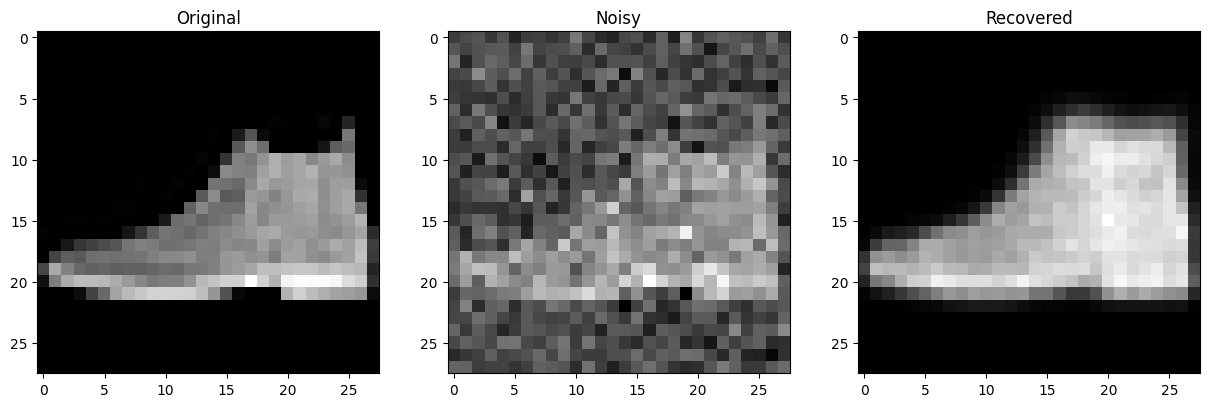

In [41]:
# 모델이 본 적 없는 테스트 이미지로 검증. -> Fashion MNIST 테스트셋
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

# 테스트셋에서 0번째 이미지 한 장을 가져와서 모델 입력으로 사용할 수 있게 차원과 값 범위 손봐주기
# 0~255 -> 0~1
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255

# 잡음 더해주고 모델 통과시키기
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

# 시각화
f, a = plt.subplots(1, 3, figsize=(15, 15))

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

잡음이 잘 제거되었음을 확인할 수 있다.